In [4]:
# === Imports ===
import os
import pandas as pd
import numpy as np
from PIL import Image
from roboflow import Roboflow
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [8]:
# === 0. CONFIG ===
METADATA_PATH = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\metadata_with_brightness.csv" 
TEST_PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\Definitief_29_04\Test_dataset\test_v5_resize"

# Roboflow settings
API_KEY = "hWGMaLWQuYEv0meKTn6j"
PROJECT_NAME = "thesis-8gv3k"  # Juiste projectnaam (kleine letters!!)
MODEL_VERSION = 8

# Output
PREDICTIONS_CSV = "predictions_output.csv"

In [9]:
# === 1. Model laden ===
rf = Roboflow(api_key=API_KEY)
project = rf.workspace().project(PROJECT_NAME)
model = project.version(MODEL_VERSION).model

# === 2. Metadata laden ===
metadata = pd.read_csv(METADATA_PATH)

# === 3. Predictions uitvoeren ===
results = []

loading Roboflow workspace...
loading Roboflow project...


In [11]:
import time

# === 3a. Measure inference speed ===
total_time = 0.0
n_samples  = 0

for idx, row in metadata.iterrows():
    patch_filename = row['patch_filename']
    prefix         = os.path.splitext(patch_filename)[0]
    brightness = row['brightness']
    light_cond = row['light_condition_new']

    patch_path = None
    true_label = None

    # Zoek het bestand in de test folders
    for class_name in os.listdir(TEST_PATCH_DIR):
        class_dir = os.path.join(TEST_PATCH_DIR, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in os.listdir(class_dir):
            # Robustly strip off the "_rf.<hash>" suffix and any extension:
            normalized = os.path.splitext(img_file)[0].split("_jpg")[0] + ".jpg"
            if normalized == patch_filename:
                patch_path = os.path.join(class_dir, img_file)
                true_label = class_name
                break
        if patch_path:
            break

    if patch_path is None:
        # Print out exactly which patch_filename failed, and list
        # the candidates in each class folder for you to debug.
        print(f"⚠️ Could not find patch '{patch_filename}'.")
        for class_name in os.listdir(TEST_PATCH_DIR):
            class_dir = os.path.join(TEST_PATCH_DIR, class_name)
            if not os.path.isdir(class_dir):
                continue
            files = os.listdir(class_dir)
            print(f"  {class_name} folder has: {[os.path.splitext(f)[0].split('_rf')[0] + '.jpg' for f in files]}")
        continue


    # — Measure start —
    t0 = time.perf_counter()

    # Voorspelling
    prediction = model.predict(patch_path)
    pred_data = prediction.json()

    # — Measure end —
    t1 = time.perf_counter()
    elapsed = t1 - t0
    total_time += elapsed
    n_samples  += 1

    if "predictions" in pred_data and len(pred_data["predictions"]) > 0:
        result = pred_data["predictions"][0]
        pred_label = result["top"]
        conf = result["confidence"]
    else:
        pred_label = "NONE"
        conf = 0.0


    results.append({
        "patch_filename": patch_filename,
        "true_label": true_label,
        "pred_label": pred_label,
        "confidence": conf,
        "brightness": brightness,
        "light_condition_new": light_cond
    })

df_results = pd.DataFrame(results)
df_results.to_csv(PREDICTIONS_CSV, index=False)
print("Saved", len(results), "predictions to", PREDICTIONS_CSV)


Saved 2200 predictions to predictions_output.csv


In [ ]:
# === 4. Opslaan (als afwijking) ===
mask_empty_pred = df_results['pred_label'].astype(str).str.strip() == ""
mask_empty_true = df_results['true_label'].astype(str).str.strip() == ""

mean_conf_other = df_results[df_results['pred_label'] == "Other"]['confidence'].mean()

df_results.loc[mask_empty, 'pred_label'] = "Other"
df_results.loc[mask_empty, 'confidence'] = mean_conf_other

df_results.to_csv(PREDICTIONS_CSV, index=False)
print(f"Predictions opgeslagen als '{PREDICTIONS_CSV}'")

Predictions opgeslagen als 'predictions_output.csv'


In [16]:
import os
import pandas as pd

# === CONFIGURATION ===
TEST_PATCH_DIR = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\Definitief_29_04\Test_dataset\test_v5"
PRED_CSV       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\predictions_output.csv"
META_CSV       = r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\metadata_with_brightness.csv"

# === 1. Build true_map from folder structure ===
true_map = {}
for cls in os.listdir(TEST_PATCH_DIR):
    cls_dir = os.path.join(TEST_PATCH_DIR, cls)
    if not os.path.isdir(cls_dir):
        continue
    for fn in os.listdir(cls_dir):
        # normalize filename by stripping any _rf hash suffix
        base = os.path.splitext(fn)[0].split("_jpg")[0] + ".jpg"
        true_map[base] = cls

# === 2. Load CSVs ===
df_pred = pd.read_csv(PRED_CSV)
df_meta = pd.read_csv(META_CSV)

# Ensure 'patch_filename' column
for df in (df_pred, df_meta):
    if 'patch_filename' not in df.columns:
        raise KeyError(f"'patch_filename' not found in {df}")

# === 3. Compare true_label in both DataFrames ===
def compare_truth(df, filename_column, true_column):
    df['derived_true'] = df[filename_column].map(true_map)
    mismatch = df[df['derived_true'] != df[true_column]]
    total = len(df)
    mismatches = len(mismatch)
    pct = mismatches / total * 100
    return mismatch, total, mismatches, pct

# Predictions CSV comparison
m_pred, tot_pred, mis_pred, pct_pred = compare_truth(df_pred, 'patch_filename', 'true_label')
print(f"Predictions CSV: {mis_pred}/{tot_pred} mismatches ({pct_pred:.2f}%)")

# Metadata CSV comparison
m_meta, tot_meta, mis_meta, pct_meta = compare_truth(df_meta, 'patch_filename', 'true_label')
print(f"Metadata CSV:    {mis_meta}/{tot_meta} mismatches ({pct_meta:.2f}%)")

# === 4. Output mismatches for inspection ===
OUT_DIR = os.path.join(os.path.dirname(PRED_CSV), "mismatch_inspection")
os.makedirs(OUT_DIR, exist_ok=True)

m_pred.to_csv(os.path.join(OUT_DIR, "predictions_mismatches.csv"), index=False)
m_meta.to_csv(os.path.join(OUT_DIR, "metadata_mismatches.csv"), index=False)

print("Mismatch rows saved to:", OUT_DIR)


Predictions CSV: 0/2200 mismatches (0.00%)
Metadata CSV:    0/2200 mismatches (0.00%)
Mismatch rows saved to: C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\mismatch_inspection


In [6]:
df_results = pd.read_csv(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\transformer\predictions_output.csv")


=== Evaluation Metrics ===
Accuracy: 0.8900
Macro F1 Score: 0.8747

                precision    recall  f1-score   support

   Clear Water       0.84      0.86      0.85       341
   Common reed       0.95      0.97      0.96       610
      Duckweed       0.81      0.92      0.86       263
         Other       0.93      0.92      0.92       591
Water-starwort       0.84      0.73      0.78       395

      accuracy                           0.89      2200
     macro avg       0.87      0.88      0.87      2200
  weighted avg       0.89      0.89      0.89      2200



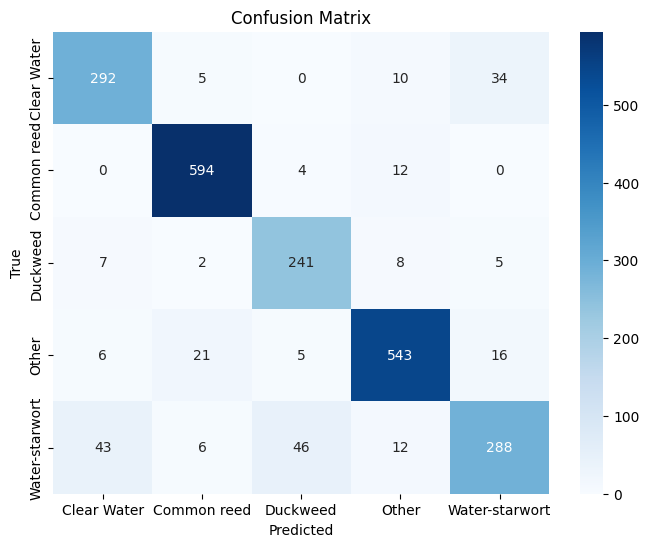

Confusion matrix saved to confusion_matrix.csv


In [10]:


# === 5. Evaluatie ===
y_true = df_results['true_label']
y_pred = df_results['pred_label']

print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save confusion matrix to CSV
cm_df = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
cm_df.to_csv(r"C:\Users\Sander\OneDrive - UGent\Semester_2\Masterproef\Thesis_ML\Roboflow\Raw_July\All_results\transformer\confusion_matrix.csv")
print("Confusion matrix saved to confusion_matrix.csv")

In [20]:
# Check for unexpected labels
print("Unique true labels:", sorted(df_results['true_label'].unique()))
print("Unique predicted labels:", sorted(df_results['pred_label'].unique()))

Unique true labels: ['Clear Water', 'Common reed', 'Duckweed', 'Other', 'Water-starwort']
Unique predicted labels: ['Clear Water', 'Common reed', 'Duckweed', 'Other', 'Water-starwort']



=== Voorbeeld foto's per klasse ===
Aantal gematchte patches: 2200

Klasse: Other


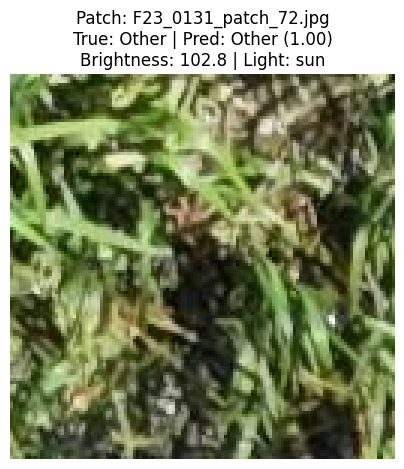

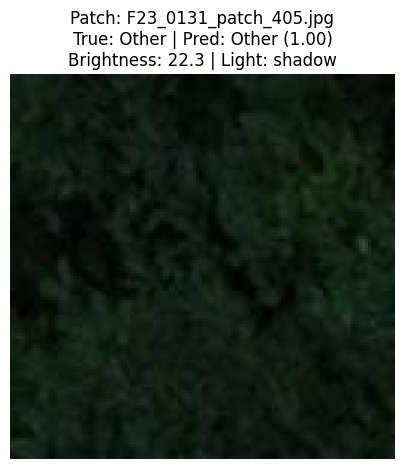

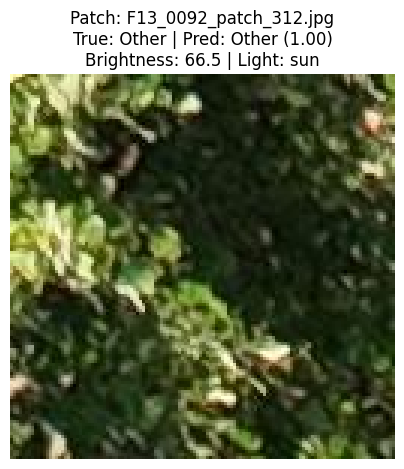

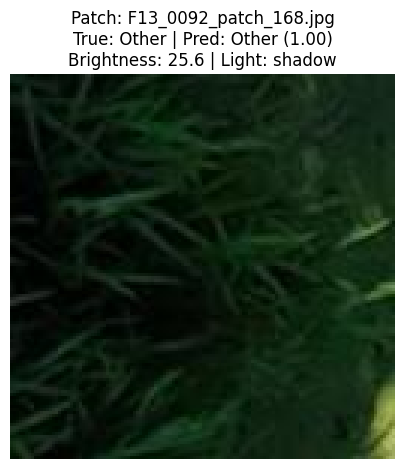

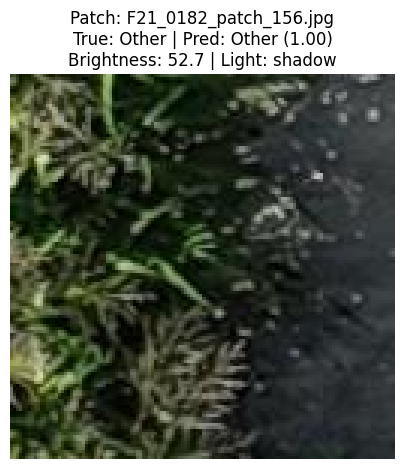


Klasse: Water-starwort


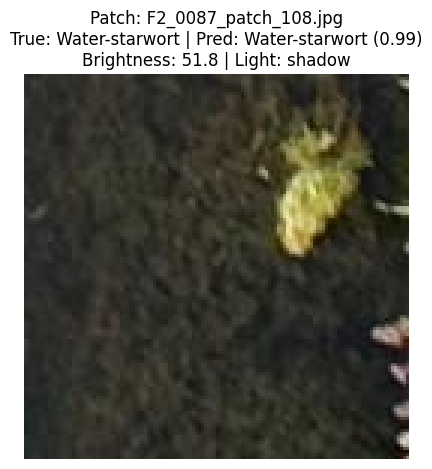

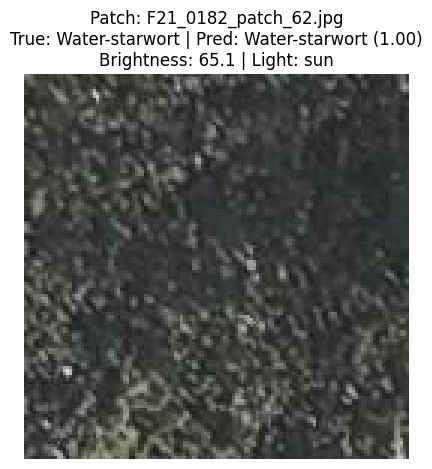

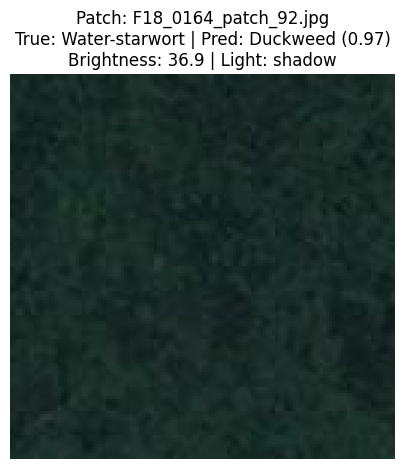

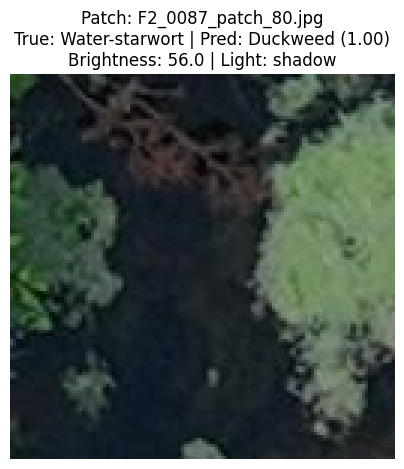

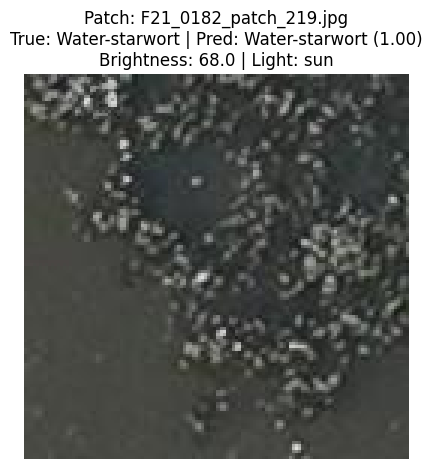


Klasse: Duckweed


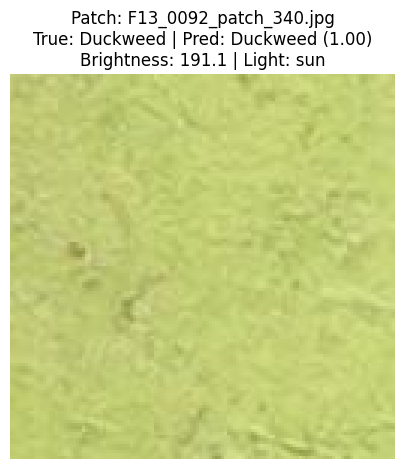

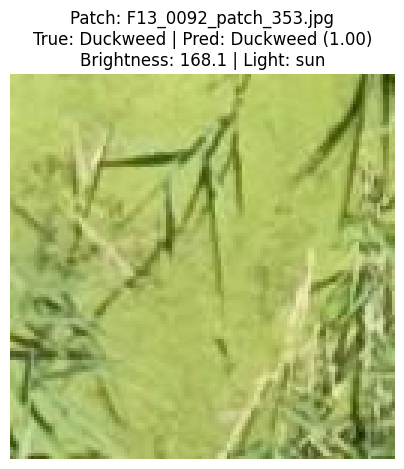

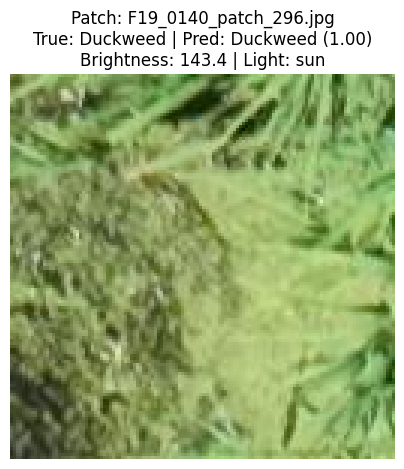

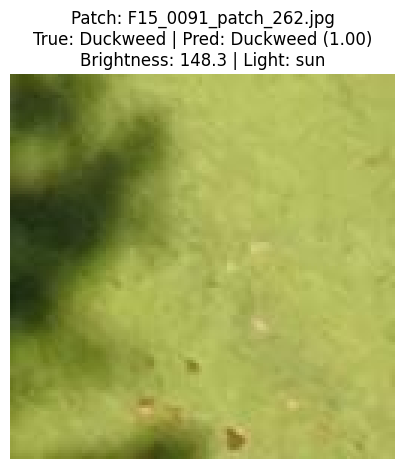

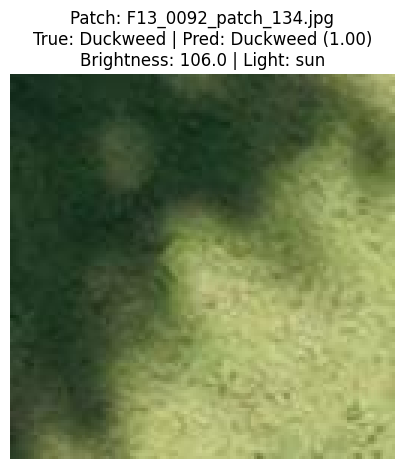


Klasse: Clear Water


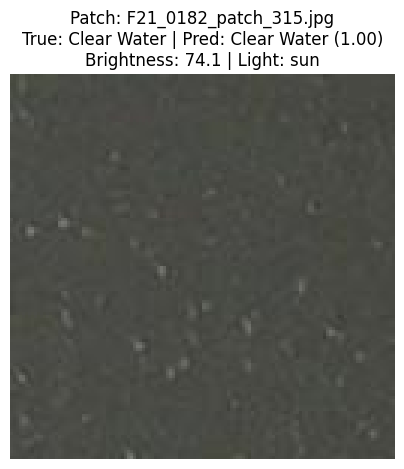

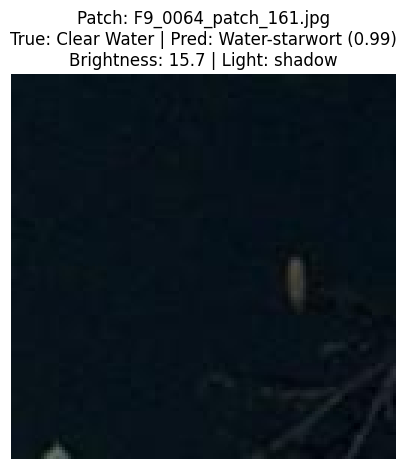

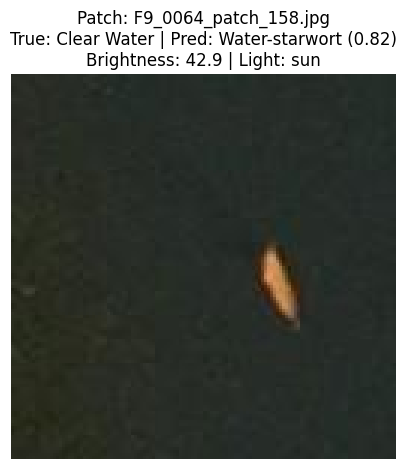

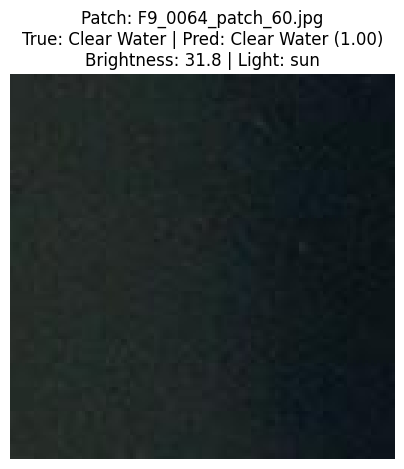

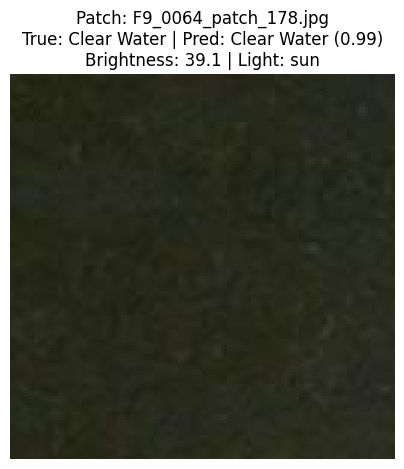


Klasse: Common reed


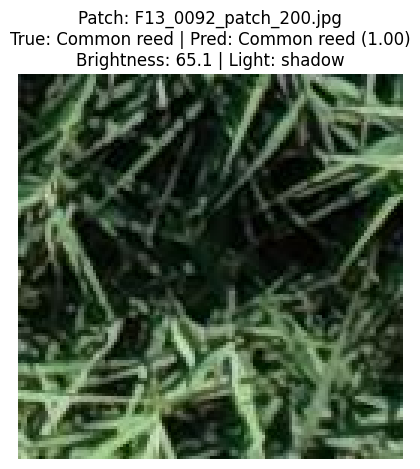

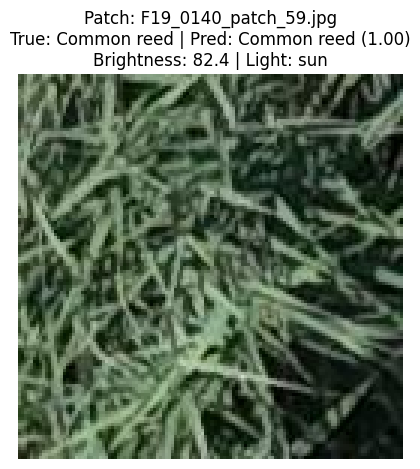

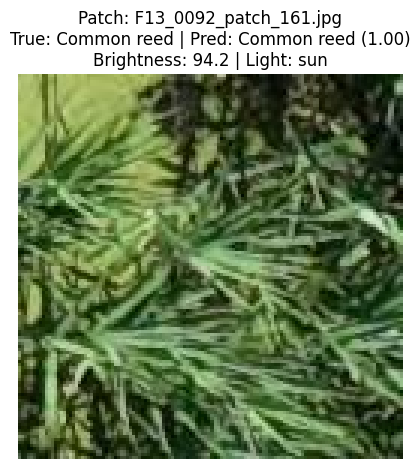

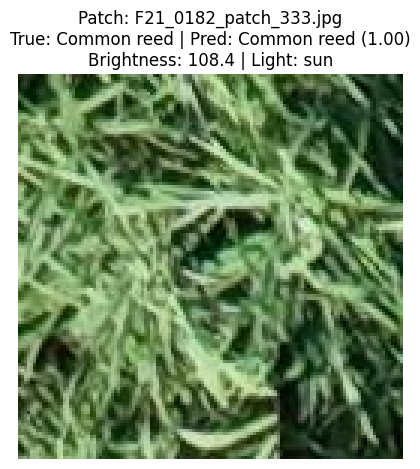

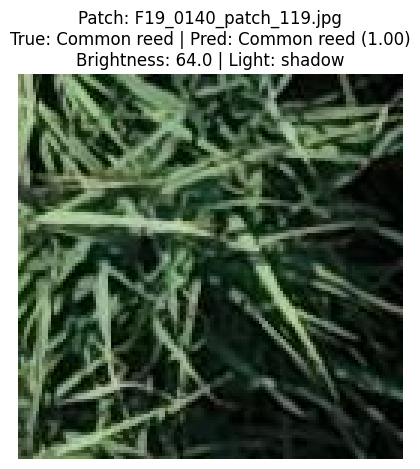

In [18]:
# === 6. VISUALISATIE PER KLASSE (verbeterd met lookup!) ===
import re  # Import the re module for regular expressions

print("\n=== Voorbeeld foto's per klasse ===")

# Stap 1: Maak een mapping patch_filename → path naar echte file
patch_to_path = {}

for class_folder in os.listdir(TEST_PATCH_DIR):
    class_path = os.path.join(TEST_PATCH_DIR, class_folder)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        # Clean de naam
        match = re.match(r"^(.*)_jpg\.rf\..*\.jpg$", img_file)
        if match:
            cleaned_patch_name = match.group(1) + ".jpg"
        else:
            cleaned_patch_name = img_file

        full_path = os.path.join(class_path, img_file)
        patch_to_path[cleaned_patch_name] = full_path

print(f"Aantal gematchte patches: {len(patch_to_path)}")

# Stap 2: Toon voorbeeld images per klasse
for klasse in df_results['true_label'].unique():
    print(f"\nKlasse: {klasse}")
    subset = df_results[df_results['true_label'] == klasse]
    samples = subset.sample(n=min(5, len(subset)), random_state=42)

    for idx, sample in samples.iterrows():
        patch_name = sample['patch_filename']
        true_label = sample['true_label']
        pred_label = sample['pred_label']
        confidence = sample['confidence']
        light_cond = sample['light_condition_new']
        brightness = sample['brightness']

        img_path = patch_to_path.get(patch_name)

        if img_path and os.path.exists(img_path):
            image = Image.open(img_path)
            plt.figure(figsize=(5,5))
            plt.imshow(image)
            plt.title(f"Patch: {patch_name}\nTrue: {true_label} | Pred: {pred_label} ({confidence:.2f})\nBrightness: {brightness:.1f} | Light: {light_cond}")
            plt.axis('off')
            plt.show()
        else:
            print(f"⚠️ Image not found for patch: {patch_name}")
